This notebook produces figure 5.

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import simulation as ctt
from rmgpy.chemkin import read_thermo_entry

In [2]:
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('paper',font_scale=1.5)

In [3]:
input_path = '../data/mechanism'
image_path = '../results/'

# plot paper figure

In [4]:
plot_OH = False

In [6]:
generalized_reactions = [['npropyloo + ROO <=> npropyloxy + RO + O2', ['2 npropyloo <=> O2 + 2 npropyloxy',
                                                                      'CH3CH2OO + npropyloo <=> O2 + ethoxy + npropyloxy',
                                                                     'CH3OO + npropyloo <=> CH3O + O2 + npropyloxy',
                                                                      'acetylperoxy + npropyloo <=> O2 + acetyloxy + npropyloxy',
                                                                     'ipropyloo + npropyloo <=> O2 + ipropyloxy + npropyloxy',]],
                         ['npropyloo + R <=> npropyloxy + RO', ['C2H5 + npropyloo <=> ethoxy + npropyloxy',
                                                               'CH3 + npropyloo <=> CH3O + npropyloxy',
                                                              'allyl + npropyloo <=> allyloxy + npropyloxy',
                                                               'ipropyl + npropyloo <=> ipropyloxy + npropyloxy',
                                                              'npropyl + npropyloo <=> 2 npropyloxy',]],
                         ['npropyloo + RH <=> npropylooh + R', ['C2H4 + npropyloo <=> C2H3 + npropylooh',
                                                               'C2H6 + npropyloo <=> C2H5 + npropylooh',
                                                               'C3H6 + npropyloo <=> allyl + npropylooh',
                                                               'C3H8 + npropyloo <=> ipropyl + npropylooh',
                                                               'C3H8 + npropyloo <=> npropyl + npropylooh',
                                                               'CH2O + npropyloo <=> HCO + npropylooh',
                                                               'CH3OH + npropyloo <=> CH2OH + npropylooh',
                                                               'CH4 + npropyloo <=> CH3 + npropylooh',
                                                               'H2 + npropyloo <=> H + npropylooh',
                                                               'acetaldehyde + npropyloo <=> acetyl + npropylooh',
                                                               'acrolein + npropyloo <=> CH2CHCO + npropylooh',
                                                               'npropyloo + propanal <=> npropylooh + propionyl',
                                                               'HO2 + npropyloo <=> O2 + npropylooh',]],
                         ['other', ['npropyloo + R <=> npropyloxy + RO', 
                                    'npropyloo <=> OH + propoxide',
                                    'npropyloo <=> QOOH_2',
                                    'NO + npropyloo <=> npropylONO2',]],]
# sorted by colors
colorblind_palette = sns.color_palette('colorblind')
ordered_palette = [colorblind_palette[4],colorblind_palette[8],colorblind_palette[3], colorblind_palette[6], colorblind_palette[2], colorblind_palette[7]]
sns.set_palette(ordered_palette)

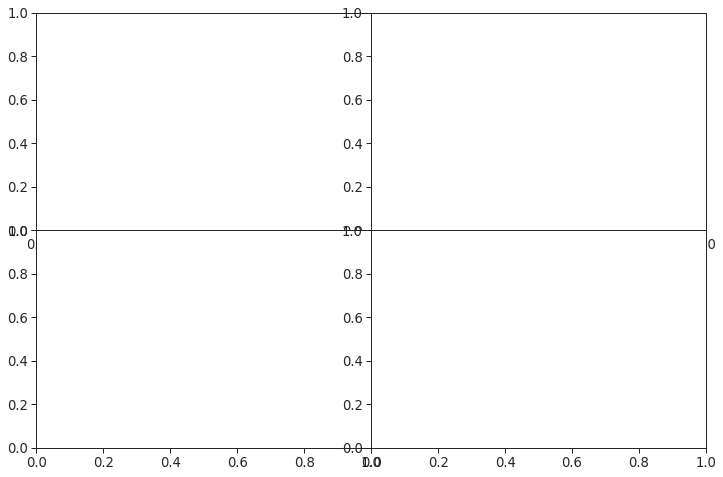

In [7]:
larger_figsize= np.array(mpl.rcParams['figure.figsize']) *2
f, axes = plt.subplots(2,2,figsize = larger_figsize,gridspec_kw={'wspace':0,'hspace':0})

In [8]:
outputs_dict = {}
for concentration_val in ['low', 'high']:
    if concentration_val == 'low':
        axes_index = 0
        NO_frac = 1.04e-12
        times = np.linspace(0,0.85,180)
    else:
        axes_index = 1
        NO_frac = 1.04e-4
        times = np.linspace(0,1,200)
    solution = ctt.create_mechanism(os.path.join(input_path,'merchant-full_w_NO.cti'))

    conditions = 650, 1e6, {'O2': 0.21, "N2": 0.79,'C3H8':0.21/5,'NO':NO_frac}
    solution.TPX = conditions
    outputs = ctt.run_simulation(solution=solution,
                                 conditions= conditions, 
                                 times = times,
                                 condition_type='adiabatic-constant-volume',
                                 output_reactions=True,
                       )
    outputs_dict[concentration_val] = outputs

In [10]:

for concentration_val in ['low', 'high']:
    if concentration_val == 'low':
        axes_index = 0
        NO_frac = 1.04e-12
        times = np.linspace(0,0.85,180)
    else:
        axes_index = 1
        NO_frac = 1.04e-4
        times = np.linspace(0,1,200)
    solution = ctt.create_mechanism(os.path.join(input_path,'merchant-full_w_NO.cti'))
    conditions = 650, 1e6, {'O2': 0.21, "N2": 0.79,'C3H8':0.21/5,'NO':NO_frac}
    solution.TPX = conditions
    outputs = outputs_dict[concentration_val]
    
    conditions = outputs['conditions']
    temperatures = conditions['temperature (K)']
    pressures = conditions['pressure (Pa)']
    densitities_mol_m3_high = conditions['density (kmol/m3)'] * 1000
    species = outputs['species'] * 1000
    rxns = outputs['net_reactions']
    ratio_full_simulation = (species['NO']/(species['NO']+species['NO2']+species['HONO']))
    if concentration_val == 'high':
        # save NO and temperature profile for plotting on the branching diagram
        df = pd.DataFrame(index = temperatures.index)
        df['temperature (K)'] = temperatures
        df['NO (frac)'] = species['NO'] / densitities_mol_m3_high
        df.to_csv(os.path.join('../data/','NO_temp_data_100_ppm.csv'))
    # remove data_points after ignition (definted by > 1000K)
    indexes_at_ignition = temperatures.index[temperatures > 1000]
    ax = axes[0][axes_index]
    ratio_full_simulation.drop(indexes_at_ignition).plot(ax=ax,logy=True,color='k')
    (1-species['C3H8']/species.loc[0,'C3H8']).drop(indexes_at_ignition).plot(ax=ax,logy=True,linestyle='--', color='k')

    secondary_ax = ax.twinx()
    temperatures.drop(indexes_at_ignition).plot(ax=secondary_ax, logy=False, linestyle='-.', color='k')
    secondary_ax.set_ylim(600, 850)
    if concentration_val=='low':
        secondary_ax.set_yticks([])
        secondary_ax.set_yticklabels([])
    else:
        secondary_ax.set_ylabel('Temperature (K)')
    
    npropyl_rxns = [rxn for rxn in rxns.columns if 'npropyloo ' in rxn]
    npropyl_rxn_rates = rxns[npropyl_rxns].copy()
    # double stoichiometric coefficient
    npropyl_rxn_rates.loc[:,u'2 npropyloo <=> O2 + 2 npropyloxy'] *=2
    #don't count reverse reactions (forming ROO)
    npropyl_rxn_rates[npropyl_rxn_rates < 0] = 0
    # still worked despite the warnings
    # remove data_points after ignition (definted by > 1000K)
    npropyl_rxn_rates.drop(indexes_at_ignition,inplace=True)
    # remove data at first time point
    npropyl_rxn_rates.drop(npropyl_rxn_rates.index[0],inplace=True)
    for general_rxn_str, specific_reactions in generalized_reactions:
        general_rxn_rate = pd.Series(index = npropyl_rxn_rates.index, data=np.zeros(len(npropyl_rxn_rates.index)))
        for specific_rxn in specific_reactions:
            general_rxn_rate += npropyl_rxn_rates[specific_rxn]
            del npropyl_rxn_rates[specific_rxn]
        npropyl_rxn_rates[general_rxn_str] = general_rxn_rate
    # normalize
    npropyl_rxn_rates = npropyl_rxn_rates.div(npropyl_rxn_rates.sum(1),0)

    npropyl_rxn_rates = npropyl_rxn_rates[[u'NO + npropyloo <=> NO2 + npropyloxy', u'npropyloo <=> QOOH_1',
           u'npropyloo <=> C3H6 + HO2', 
           u'npropyloo + ROO <=> npropyloxy + RO + O2', u'npropyloo + RH <=> npropylooh + R',u'other']]
    ax_area_plot = axes[1][axes_index]
    npropyl_rxn_rates.plot.area(ax=ax_area_plot, linewidth=0)
    ax_area_plot.get_legend().remove()

    if concentration_val == 'low':
        ax_area_plot.annotate('alkoxy from ROO', (0.27,0.6),rotation=-20)
        ax_area_plot.annotate('chain oxidation',(0.15,0.2))
        ax_area_plot.annotate('HO$_2$ elimination',(0.49,0.48))
        ax_area_plot.annotate('ROOH formation',(0.48,0.83))
        ax_area_plot.annotate('other',(0.7,0.94))
    else:
        ax_area_plot.annotate('alkoxy\nfrom NO',(0.05,0.45))
        ax_area_plot.annotate('alkoxy from ROO',(0.41,0.6),rotation=-25)
        ax_area_plot.annotate('chain oxidation',(0.35,0.2))
        ax_area_plot.annotate('HO$_2$ elimination',(0.62,0.48))
        ax_area_plot.annotate('ROOH formation',(0.58,0.84))
        ax_area_plot.annotate('other',(0.8,0.94))

    ax_area_plot.set_ylabel('npropylperoxy branching ratio')

In [11]:
axis = axes[0][0]
axis.set_ylim(1.04e-6,1.1)
axis.annotate('NO/NOy',(0.36,3e-6))
axis.annotate('fraction propane consumed',(0.180,0.6e-3),rotation=27)
axis.annotate('temp.',(0.02,2.5e-5))
axis.set_xticks([])
axis.set_xticklabels([])
axis.set_ylabel('fraction')

axis = axes[0][1]
axis.set_ylim(1.04e-6,1.1)
axis.set_ylabel('')
axis.set_yticklabels([])
axis.set_yticks([])
axis.tick_params(which='minor',left=False)
axis.annotate('NO/NOy',(0.53,4e-6))
axis.annotate('temperature',(0.15,2.5e-5))
axis.annotate('fraction propane consumed',(0.29,0.5e-3),rotation=27)
axis.set_xticks([])
axis.set_xticklabels([])

axis = axes[1][1]
axis.set_yticklabels([])
axis.set_ylabel('')
axis.set_yticks([])
axis.set_ylim((0, 1))

# set title
ax = axes[0][0]
ax.set_title('1 ppt NO')
ax = axes[0][1]
ax.set_title('100 ppm NO')

axis = axes[1][0]
axis.set_ylim((0, 1))

(0.0, 1.0)

In [12]:
for axes_index_0 in [0, 1]:
    for axes_index_1 in [0, 1]:
        axes[axes_index_0][axes_index_1].set_xlim(0, 1)
        if axes_index_1 == 1:
            axes[axes_index_0][axes_index_1].set_xticks([0,0.2,0.4,0.6,0.8,1])
        else:
            axes[axes_index_0][axes_index_1].set_xticks([0,0.2,0.4,0.6,0.8])

In [14]:
f.savefig(os.path.join(image_path,'branching_pathways_propane_combustion.svg'),bbox_inches='tight')
f.savefig(os.path.join(image_path,'branching_pathways_propane_combustion.pdf'),bbox_inches='tight')